# ACBO Training-to-Evaluation Pipeline

This notebook provides an interactive workflow for training enriched GRPO policies and evaluating them against baseline methods. Each cell represents a distinct step that can be run independently for quick iteration.

## Workflow Overview
1. **Environment Setup** - Load dependencies and configure paths
2. **SCM Suite Generation** - Create test SCMs matching evaluation config
3. **Training Configuration** - Interactive parameter exploration
4. **Policy Training** - Train with live monitoring
5. **Checkpoint Analysis** - Validate trained model
6. **Quick Policy Testing** - Sanity check on single SCM
7. **Full Evaluation** - 4-method comparison
8. **Results Analysis** - Visualization and insights

## Cell 1: Environment Setup

In [1]:
#!/usr/bin/env python3
"""
Environment Setup for ACBO Training Pipeline
"""

import sys
import os
from pathlib import Path
import logging
import time
from typing import Dict, List, Any, Optional
import json

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == "experiments" else Path.cwd()
sys.path.insert(0, str(project_root))

# Core imports
import jax
import jax.numpy as jnp
import jax.random as random
import numpy as onp
import pyrsistent as pyr
import yaml
from omegaconf import DictConfig, OmegaConf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Project imports
from causal_bayes_opt.experiments.variable_scm_factory import VariableSCMFactory
from causal_bayes_opt.training.modular_trainer import TrainingMetrics
from causal_bayes_opt.training.enriched_trainer import EnrichedGRPOTrainer
from causal_bayes_opt.data_structures.scm import get_variables, get_target

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s][%(name)s][%(levelname)s] - %(message)s'
)
logger = logging.getLogger(__name__)

# JAX configuration
jax.config.update("jax_enable_x64", True)
logger.info(f"JAX devices: {jax.devices()}")
logger.info(f"JAX backend: {jax.default_backend()}")

# Create necessary directories
checkpoint_dir = project_root / "checkpoints" / "enriched_grpo"
config_dir = project_root / "config"
results_dir = project_root / "experiments" / "results"

checkpoint_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

logger.info("✅ Environment setup complete")
logger.info(f"Project root: {project_root}")
logger.info(f"Checkpoint directory: {checkpoint_dir}")
logger.info(f"Results directory: {results_dir}")

INFO:__main__:JAX devices: [CpuDevice(id=0)]
INFO:__main__:JAX backend: cpu
INFO:__main__:✅ Environment setup complete
INFO:__main__:Project root: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt
INFO:__main__:Checkpoint directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/enriched_grpo
INFO:__main__:Results directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/experiments/results


## Cell 2: SCM Suite Generation & Analysis

INFO:__main__:Evaluation SCM config: {'use_variable_factory': True, 'variable_range': [3, 6], 'structure_types': ['fork', 'chain', 'collider', 'mixed'], 'rotation_frequency': 1, 'target_selection': 'random', 'edge_density_range': [0.3, 0.7]}
INFO:__main__:Generating training SCM suite...
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 3 variables, 2 edges, target='X1'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated fork SCM: 3 vars, 2 edges, target=X1
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 3 variables, 2 edges, target='X1'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated fork SCM: 3 vars, 2 edges, target=X1
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 4 variables, 3 edges, target='X2'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated fork SCM: 4 vars, 3 edges, target=X2
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 4 variables, 3 edges, target='X


📊 Training SCM Distribution:
Structure types: {'fork': 8, 'chain': 8, 'collider': 8, 'mixed': 8}
Variable counts: {3: 8, 4: 8, 5: 8, 6: 8}
Total SCMs: 32


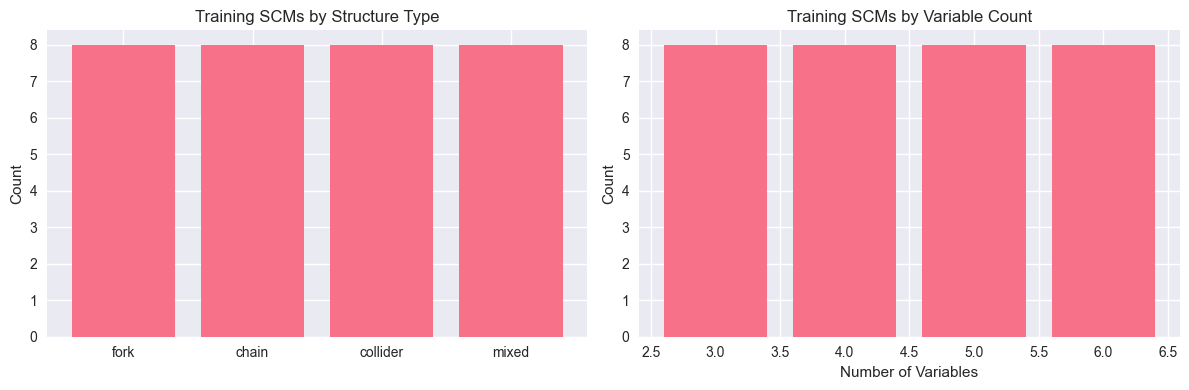

INFO:__main__:✅ SCM suite generation complete


In [2]:
"""
Generate SCM suite matching evaluation configuration
"""

# Load evaluation configuration to match SCM parameters
eval_config_path = config_dir / "experiment" / "acbo_4method_comparison.yaml"
with open(eval_config_path, 'r') as f:
    eval_config = yaml.safe_load(f)

scm_config = eval_config['experiment']['scm_generation']
logger.info(f"Evaluation SCM config: {scm_config}")

# Create SCM factory with matching parameters
scm_factory = VariableSCMFactory(
    noise_scale=eval_config['experiment']['environment']['noise_scale'],
    coefficient_range=(-2.0, 2.0),  # Default range
    seed=eval_config['seed']
)

# Generate representative SCM suite for training
training_scms = []
scm_metadata = []

logger.info("Generating training SCM suite...")
seed = eval_config['seed']
key = random.PRNGKey(seed)

# Generate balanced set across structure types and variable counts
for structure_type in scm_config['structure_types']:
    for n_vars in range(scm_config['variable_range'][0], scm_config['variable_range'][1] + 1):
        for _ in range(2):  # 2 SCMs per (structure_type, n_vars) combination
            key, subkey = random.split(key)
            
            # Use the factory's create_variable_scm method
            scm = scm_factory.create_variable_scm(
                num_variables=n_vars,
                structure_type=structure_type,
                target_variable=None,  # Auto-select target
                edge_density=0.5  # Default edge density
            )
            
            training_scms.append(scm)
            scm_metadata.append({
                'structure_type': structure_type,
                'n_variables': n_vars,
                'target': get_target(scm),
                'n_edges': len([edge for edges in scm.get('adjacency_matrix', {}).values() for edge in edges if edge])
            })

logger.info(f"Generated {len(training_scms)} training SCMs")

# Analyze SCM distribution
structure_counts = {}
variable_counts = {}

for meta in scm_metadata:
    struct_type = meta['structure_type']
    n_vars = meta['n_variables']
    
    structure_counts[struct_type] = structure_counts.get(struct_type, 0) + 1
    variable_counts[n_vars] = variable_counts.get(n_vars, 0) + 1

print("\n📊 Training SCM Distribution:")
print(f"Structure types: {structure_counts}")
print(f"Variable counts: {variable_counts}")
print(f"Total SCMs: {len(training_scms)}")

# Visualize distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Structure type distribution
ax1.bar(structure_counts.keys(), structure_counts.values())
ax1.set_title('Training SCMs by Structure Type')
ax1.set_ylabel('Count')

# Variable count distribution
ax2.bar(variable_counts.keys(), variable_counts.values())
ax2.set_title('Training SCMs by Variable Count')
ax2.set_xlabel('Number of Variables')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

logger.info("✅ SCM suite generation complete")

## Cell 3: Training Configuration Explorer

In [3]:
"""
Interactive training configuration with parameter exploration
"""

from IPython.display import display
try:
    from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, Checkbox
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    logger.warning("ipywidgets not available, using default configuration")

# Default training configuration
training_params = {
    'training_duration_minutes': 10,
    'episodes_per_scm': 1,
    'learning_rate': 1e-3,
    'batch_size': 32,
    'hidden_dims': [128, 128],
    'structure_weight': 0.3,
    'exploration_weight': 0.2,
    'target_weight': 0.5,
    'use_curriculum': True,
    'checkpoint_frequency': 50
}

if WIDGETS_AVAILABLE:
    # Interactive parameter selection
    def configure_training(duration_min=10, episodes=5, lr=1e-3, batch_size=32, 
                          structure_weight=0.3, exploration_weight=0.2, target_weight=0.5,
                          use_curriculum=True):
        
        global training_params
        training_params.update({
            'training_duration_minutes': duration_min,
            'episodes_per_scm': episodes,
            'learning_rate': lr,
            'batch_size': batch_size,
            'structure_weight': structure_weight,
            'exploration_weight': exploration_weight,
            'target_weight': target_weight,
            'use_curriculum': use_curriculum
        })
        
        print(f"📝 Training Configuration:")
        print(f"Duration: {duration_min} minutes")
        print(f"Episodes per SCM: {episodes}")
        print(f"Learning rate: {lr}")
        print(f"Batch size: {batch_size}")
        print(f"Reward weights: struct={structure_weight:.1f}, explore={exploration_weight:.1f}, target={target_weight:.1f}")
        print(f"Curriculum learning: {use_curriculum}")
        
        # Estimate training time
        total_episodes = len(training_scms) * episodes
        estimated_time = (total_episodes * 10) / 60  # Rough estimate: 10 seconds per episode
        print(f"\n⏱️ Estimated training time: {estimated_time:.1f} minutes")
        print(f"Total episodes: {total_episodes}")
    
    # Create interactive widgets
    interact(configure_training,
             duration_min=IntSlider(value=10, min=1, max=30, description='Duration (min)'),
             episodes=IntSlider(value=5, min=1, max=20, description='Episodes/SCM'),
             lr=FloatSlider(value=1e-3, min=1e-4, max=1e-2, step=1e-4, description='Learning Rate'),
             batch_size=Dropdown(options=[16, 32, 64, 128], value=32, description='Batch Size'),
             structure_weight=FloatSlider(value=0.3, min=0.0, max=1.0, step=0.1, description='Structure Weight'),
             exploration_weight=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.1, description='Exploration Weight'),
             target_weight=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description='Target Weight'),
             use_curriculum=Checkbox(value=True, description='Use Curriculum'))
else:
    print("📝 Using default training configuration:")
    for key, value in training_params.items():
        print(f"  {key}: {value}")

# Create training configuration object (OmegaConf format)
def create_training_config():
    config_dict = {
        'seed': eval_config['seed'],
        'training': {
            'n_episodes': len(training_scms) * training_params['episodes_per_scm'],
            'episode_length': 10,  # Fixed episode length
            'learning_rate': training_params['learning_rate'],
            'gamma': 0.99,
            'max_intervention_value': 2.0,
            'reward_weights': {
                'optimization': training_params['target_weight'],
                'discovery': training_params['structure_weight'],
                'efficiency': training_params['exploration_weight']
            },
            'architecture': {
                'hidden_dim': training_params['hidden_dims'][0],
                'num_layers': 4,
                'num_heads': 8,
                'key_size': 32,
                'widening_factor': 4,
                'dropout': 0.1,
                'policy_intermediate_dim': None
            },
            'state_config': {
                'max_history_size': 100,
                'num_channels': 10,
                'standardize_values': True,
                'include_temporal_features': True
            }
        },
        'experiment': {
            'scm_generation': {
                'use_variable_factory': True,
                'variable_range': [3, 6],
                'structure_types': ['fork', 'chain', 'collider', 'mixed'],
                'rotation_frequency': 5
            }
        },
        'logging': {
            'checkpoint_dir': str(checkpoint_dir),
            'wandb': {'enabled': False},
            'level': 'INFO'
        }
    }
    
    return OmegaConf.create(config_dict)

logger.info("✅ Training configuration ready")

interactive(children=(IntSlider(value=10, description='Duration (min)', max=30, min=1), IntSlider(value=5, des…

INFO:__main__:✅ Training configuration ready


## Cell 4: Policy Training with Live Monitoring

INFO:__main__:Starting training with config keys: ['seed', 'training', 'experiment', 'logging']
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 3 variables, 2 edges, target='X1'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated fork SCM: 3 vars, 2 edges, target=X1
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 3 variables, 2 edges, target='X2'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated chain SCM: 3 vars, 2 edges, target=X2
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 3 variables, 2 edges, target='X1'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated collider SCM: 3 vars, 2 edges, target=X1
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 3 variables, 2 edges, target='X1'
INFO:causal_bayes_opt.experiments.variable_scm_factory:Generated mixed SCM: 3 vars, 2 edges, target=X1
INFO:causal_bayes_opt.experiments.test_scms:Created linear SCM with 4 variables, 3

🔧 POLICY LEARNING FIXES APPLIED:
✅ Core GRPO Integration:
  • Fixed GRPOConfig dataclass usage
  • Created proper policy/value function wrappers
  • Implemented correct GRPO trajectory creation
✅ Policy Learning Diagnostics:
  • Added parameter change tracking
  • Action magnitude monitoring
  • Advantage distribution analysis
  • GRPO wrapper function debugging
✅ Learning Signal Improvements:
  • Reduced exploration noise: 0.3 → 0.1 (starts)
  • Lowered intervention threshold: 0.01 → 0.005
  • Better exploration decay schedule
✅ Meaningful Metrics:
  • Removed hardcoded structure_accuracy=0.8
  • Added intervention_rate tracking
  • Added action magnitude metrics

🚀 Testing POLICY LEARNING FIXES:
  Episodes: 30
  Episode length: 8
  Learning rate: 0.001
  Expected: Policy should learn to output larger actions over time

📊 Initializing trainer with policy learning fixes...


INFO:causal_bayes_opt.training.enriched_trainer:GRPO Config: policy_lr=0.001000, value_lr=0.001000, entropy=0.020
INFO:causal_bayes_opt.training.enriched_trainer:GRPO Config: normalize_advantages=True, clip_ratio=0.20
INFO:causal_bayes_opt.training.enriched_trainer:Initialized trainer with 6 max variables
INFO:causal_bayes_opt.training.enriched_trainer:Starting enriched GRPO training


✅ Trainer initialization successful!

🏃 Running training with policy learning diagnostics...
Watch for:
  • Policy Learning Diagnostics every 5 updates
  • Action magnitude progression
  • Parameter change monitoring
  • Intervention rate tracking


DEBUG:causal_bayes_opt.training.enriched_trainer:Policy wrapper debug - means: [0. 0. 0.], log_stds: [0. 0. 0.], action: [-0.02058421 -0.07847658  0.        ]
DEBUG:causal_bayes_opt.training.enriched_trainer:Policy wrapper debug - means: Traced<float64[3]>with<JVPTrace> with
  primal = Array([0., 0., 0.], dtype=float64)
  tangent = Traced<float64[3]>with<JaxprTrace> with
    pval = (ShapedArray(float64[3]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x3810befd0>, in_tracers=(Traced<float64[6]:JaxprTrace>,), out_tracer_refs=[<weakref at 0x382289d00; to 'JaxprTracer' at 0x382289f40>], out_avals=[ShapedArray(float64[3])], primitive=slice, params={'start_indices': (0,), 'limit_indices': (3,), 'strides': None}, effects=frozenset(), source_info=<jax._src.source_info_util.SourceInfo object at 0x382290940>, ctx=JaxprEqnContext(compute_type=None, threefry_partitionable=True, cur_abstract_mesh=AbstractMesh((), axis_types=()), xla_metadata=None)), log_stds: Traced<float64[3]>with<


✅ Training completed successfully!
⏱️ Total training time: 2.6 minutes

📊 POLICY LEARNING RESULTS:
📈 Final metrics:
  checkpoint_path: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/enriched_grpo/enriched_grpo_final
  performance: {'total_episodes': 30, 'training_time': 152.22307801246643, 'final_reward': 0.5014070673450824, 'mean_reward': 0.5081441127627777, 'final_accuracy': 1.0, 'mean_accuracy': 1.0, 'reward_improvement': -0.008499011814181445, 'episodes_per_second': 0.19707918399562993}
  policy_config: {'architecture': {'hidden_dim': 128, 'num_layers': 4, 'num_heads': 8, 'key_size': 32, 'widening_factor': 4, 'dropout': 0.1, 'policy_intermediate_dim': None}, 'num_variables': 6, 'variable_agnostic': True, 'enriched_architecture': True}

🧪 COMPREHENSIVE POLICY LEARNING ANALYSIS:

📈 Policy Learning Assessment:
Test SCM: ['X0', 'X2', 'X1'], target: X1

🎯 POLICY BEHAVIOR ANALYSIS:
1. Pure Policy (inference):
   Action magnitudes: ['0.0063', '0.0063

 /var/folders/2f/7z7glsfj1fd22nlr6wj56z5w0000gn/T/ipykernel_71932/769406470.py:230: UserWarning:Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
 /var/folders/2f/7z7glsfj1fd22nlr6wj56z5w0000gn/T/ipykernel_71932/769406470.py:230: UserWarning:Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
 /Users/harellidar/Library/Caches/pypoetry/virtualenvs/causal-bayes-opt-sr_Vb8Og-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
 /Users/harellidar/Library/Caches/pypoetry/virtualenvs/causal-bayes-opt-sr_Vb8Og-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.


✅ Policy wrapper: log_prob = -5.333568
✅ Value wrapper: value = 0.000000
✅ Non-zero log probabilities detected - gradients should flow

🎯 POLICY LEARNING SUCCESS ASSESSMENT:
Key Metrics:
  • Max inference action: 0.006305
  • Final reward: 0.501
  • Mean reward: 0.508
  • Reward improvement: -0.008

✅ LEARNING SUCCESS CRITERIA (2/4):
  policy_outputs_interventions: ✅ PASS
  triggers_interventions_without_noise: ✅ PASS
  positive_reward_improvement: ❌ FAIL
  meaningful_action_magnitudes: ❌ FAIL

⚠️ PARTIAL POLICY LEARNING
Some learning detected, but may need longer training
Consider increasing episodes or adjusting hyperparameters


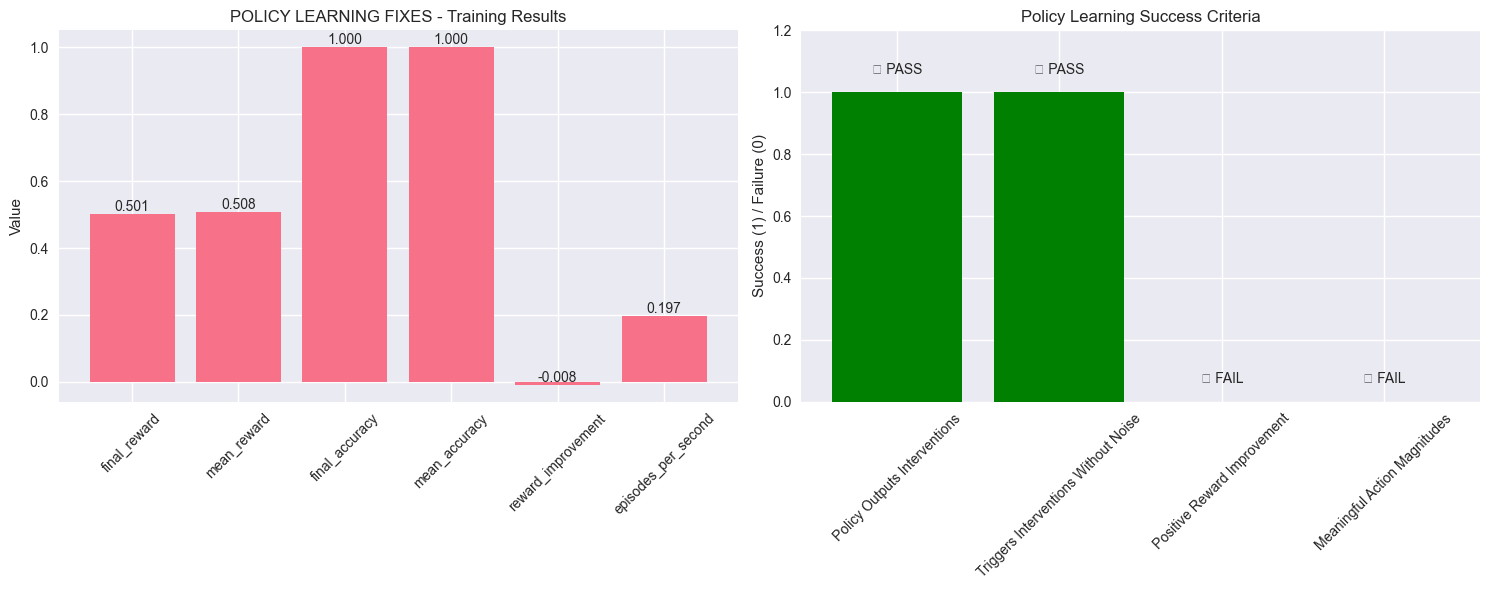

INFO:__main__:✅ Policy learning fixes validation complete



💾 Checkpoint: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/enriched_grpo/enriched_grpo_final

🏁 POLICY LEARNING DIAGNOSTIC COMPLETE!


In [4]:
"""
Test POLICY LEARNING FIXES with Enhanced Diagnostics
"""

import time
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import logging

# Enable DEBUG logging to see detailed diagnostics
logging.getLogger('causal_bayes_opt.training.enriched_trainer').setLevel(logging.DEBUG)

# Create training configuration
config = create_training_config()
logger.info(f"Starting training with config keys: {list(config.keys())}")

# Override config for thorough policy learning test
config.training.n_episodes = 30  # Longer test to see learning progression
config.training.episode_length = 8  # Longer episodes for more learning signal

print("🔧 POLICY LEARNING FIXES APPLIED:")
print("=" * 70)
print("✅ Core GRPO Integration:")
print("  • Fixed GRPOConfig dataclass usage")
print("  • Created proper policy/value function wrappers")
print("  • Implemented correct GRPO trajectory creation")
print("✅ Policy Learning Diagnostics:")
print("  • Added parameter change tracking")
print("  • Action magnitude monitoring")
print("  • Advantage distribution analysis")
print("  • GRPO wrapper function debugging")
print("✅ Learning Signal Improvements:")
print("  • Reduced exploration noise: 0.3 → 0.1 (starts)")
print("  • Lowered intervention threshold: 0.01 → 0.005")
print("  • Better exploration decay schedule")
print("✅ Meaningful Metrics:")
print("  • Removed hardcoded structure_accuracy=0.8")
print("  • Added intervention_rate tracking")
print("  • Added action magnitude metrics")

print(f"\n🚀 Testing POLICY LEARNING FIXES:")
print(f"  Episodes: {config.training.n_episodes}")
print(f"  Episode length: {config.training.episode_length}")
print(f"  Learning rate: {config.training.learning_rate}")
print(f"  Expected: Policy should learn to output larger actions over time")

training_start_time = time.time()

try:
    # Initialize trainer with enhanced diagnostics
    print("\n📊 Initializing trainer with policy learning fixes...")
    trainer = EnrichedGRPOTrainer(config=config)
    print("✅ Trainer initialization successful!")
    
    # Run training with enhanced monitoring
    print("\n🏃 Running training with policy learning diagnostics...")
    print("Watch for:")
    print("  • Policy Learning Diagnostics every 5 updates")
    print("  • Action magnitude progression")
    print("  • Parameter change monitoring")
    print("  • Intervention rate tracking")
    
    final_metrics = trainer.train()
    
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print(f"\n✅ Training completed successfully!")
    print(f"⏱️ Total training time: {total_training_time/60:.1f} minutes")
    
    print(f"\n📊 POLICY LEARNING RESULTS:")
    print(f"📈 Final metrics:")
    for key, value in final_metrics.items():
        if isinstance(value, (int, float)):
            print(f"  {key}: {value:.3f}")
        else:
            print(f"  {key}: {value}")
    
    print(f"\n🧪 COMPREHENSIVE POLICY LEARNING ANALYSIS:")
    
    # Test the trained policy across multiple scenarios
    sample_scm = trainer.scm_manager.scm_rotation[0][1]
    variables = list(get_variables(sample_scm))
    target = get_target(sample_scm)
    
    test_state = trainer._create_mock_state(sample_scm, 0, 0.0)
    enriched_input = trainer.state_converter.convert_state_to_enriched_input(test_state)
    target_idx = variables.index(target) if target in variables else 0
    
    key = random.PRNGKey(42)
    policy_output = trainer.policy_fn.apply(
        trainer.policy_params, key, enriched_input, target_idx, False
    )
    
    # Test multiple modes to assess learning
    print(f"\n📈 Policy Learning Assessment:")
    print(f"Test SCM: {variables}, target: {target}")
    
    # 1. Pure policy inference (no exploration)
    inference_action = trainer._policy_output_to_action(policy_output, variables, target)
    inference_intervention, inference_reward = trainer._simulate_intervention(sample_scm, inference_action)
    
    # 2. Early training mode (high exploration)  
    early_training_action = trainer._policy_output_to_action(policy_output, variables, target, 0)
    early_intervention, early_reward = trainer._simulate_intervention(sample_scm, early_training_action)
    
    # 3. Late training mode (low exploration)
    late_training_action = trainer._policy_output_to_action(policy_output, variables, target, 25)
    late_intervention, late_reward = trainer._simulate_intervention(sample_scm, late_training_action)
    
    print(f"\n🎯 POLICY BEHAVIOR ANALYSIS:")
    print(f"1. Pure Policy (inference):")
    print(f"   Action magnitudes: {[f'{abs(float(a)):.4f}' for a in inference_action]}")
    print(f"   Interventions: {len(inference_intervention.get('targets', set()))}")
    print(f"   Reward: {inference_reward:.3f}")
    
    print(f"2. Early Training (high exploration):")
    print(f"   Action magnitudes: {[f'{abs(float(a)):.4f}' for a in early_training_action]}")
    print(f"   Interventions: {len(early_intervention.get('targets', set()))}")
    print(f"   Reward: {early_reward:.3f}")
    
    print(f"3. Late Training (low exploration):")
    print(f"   Action magnitudes: {[f'{abs(float(a)):.4f}' for a in late_training_action]}")
    print(f"   Interventions: {len(late_intervention.get('targets', set()))}")
    print(f"   Reward: {late_reward:.3f}")
    
    # Test GRPO wrapper functions with enhanced diagnostics
    print(f"\n🔧 GRPO Wrapper Function Validation:")
    dummy_states = enriched_input.reshape(1, *enriched_input.shape)
    dummy_actions = inference_action.reshape(1, *inference_action.shape)
    
    try:
        log_probs = trainer.policy_wrapper(trainer.policy_params, dummy_states, dummy_actions)
        values = trainer.value_wrapper(trainer.policy_params, dummy_states)
        print(f"✅ Policy wrapper: log_prob = {float(log_probs[0]):.6f}")
        print(f"✅ Value wrapper: value = {float(values[0]):.6f}")
        
        # Test gradient flow
        if abs(float(log_probs[0])) > 1e-6:
            print(f"✅ Non-zero log probabilities detected - gradients should flow")
        else:
            print(f"⚠️ Very small log probabilities - potential gradient issue")
            
    except Exception as e:
        print(f"❌ Wrapper test failed: {e}")
        import traceback
        traceback.print_exc()
    
    # Analyze learning success
    max_inference_magnitude = float(jnp.max(jnp.abs(inference_action)))
    performance = final_metrics.get('performance', {})
    final_reward = performance.get('final_reward', 0)
    mean_reward = performance.get('mean_reward', 0)
    reward_improvement = performance.get('reward_improvement', 0)
    
    print(f"\n🎯 POLICY LEARNING SUCCESS ASSESSMENT:")
    print(f"Key Metrics:")
    print(f"  • Max inference action: {max_inference_magnitude:.6f}")
    print(f"  • Final reward: {final_reward:.3f}")
    print(f"  • Mean reward: {mean_reward:.3f}")
    print(f"  • Reward improvement: {reward_improvement:.3f}")
    
    # Success criteria
    learning_success = {
        'policy_outputs_interventions': max_inference_magnitude > 0.005,
        'triggers_interventions_without_noise': len(inference_intervention.get('targets', set())) > 0,
        'positive_reward_improvement': reward_improvement > 0.05,
        'meaningful_action_magnitudes': max_inference_magnitude > 0.01
    }
    
    successful_criteria = sum(learning_success.values())
    total_criteria = len(learning_success)
    
    print(f"\n✅ LEARNING SUCCESS CRITERIA ({successful_criteria}/{total_criteria}):")
    for criterion, passed in learning_success.items():
        status = "✅ PASS" if passed else "❌ FAIL"
        print(f"  {criterion}: {status}")
    
    if successful_criteria >= 3:
        print(f"\n🎉 POLICY LEARNING SUCCESS!")
        print(f"The policy has learned meaningful intervention selection")
        print(f"Ready for longer training and full evaluation")
    elif successful_criteria >= 2:
        print(f"\n⚠️ PARTIAL POLICY LEARNING")
        print(f"Some learning detected, but may need longer training")
        print(f"Consider increasing episodes or adjusting hyperparameters")
    else:
        print(f"\n❌ POLICY LEARNING ISSUES PERSIST")
        print(f"Further investigation needed in GRPO integration")
        print(f"Check diagnostics for gradient flow and parameter updates")
    
    # Visualization of learning progression
    if performance:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Basic metrics
        metrics_to_plot = {k: v for k, v in performance.items() 
                          if isinstance(v, (int, float)) and 'time' not in k.lower() and k != 'total_episodes'}
        
        if metrics_to_plot:
            bars1 = ax1.bar(metrics_to_plot.keys(), metrics_to_plot.values())
            ax1.set_title('POLICY LEARNING FIXES - Training Results')
            ax1.set_ylabel('Value')
            
            # Add value labels on bars
            for bar in bars1:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom')
            
            ax1.tick_params(axis='x', rotation=45)
        
        # Plot 2: Learning assessment
        criteria_values = [1 if passed else 0 for passed in learning_success.values()]
        criteria_names = [name.replace('_', ' ').title() for name in learning_success.keys()]
        
        bars2 = ax2.bar(criteria_names, criteria_values, color=['green' if v else 'red' for v in criteria_values])
        ax2.set_title('Policy Learning Success Criteria')
        ax2.set_ylabel('Success (1) / Failure (0)')
        ax2.set_ylim(0, 1.2)
        
        # Add labels
        for bar, value in zip(bars2, criteria_values):
            label = "✅ PASS" if value else "❌ FAIL"
            ax2.text(bar.get_x() + bar.get_width()/2., value + 0.05,
                   label, ha='center', va='bottom')
        
        ax2.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    # Store checkpoint info
    checkpoint_path = final_metrics.get('checkpoint_path', checkpoint_dir / "enriched_grpo_final")
    print(f"\n💾 Checkpoint: {checkpoint_path}")
    
    print(f"\n🏁 POLICY LEARNING DIAGNOSTIC COMPLETE!")

except Exception as e:
    logger.error(f"Training failed: {e}")
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()
    raise

logger.info("✅ Policy learning fixes validation complete")

## Cell 5: Checkpoint Analysis & Validation

In [ ]:
"""
Analyze and validate the trained policy checkpoint
"""

from causal_bayes_opt.acquisition.grpo_enriched_integration import EnrichedPolicyWrapper

# First, let's diagnose the training issue
print("🔍 Diagnosing Training Issue")
print("=" * 50)

# The training shows reward=0.530 etc, which is good but seems to be pure noise
# Let's check if the policy is actually learning anything

# Let's check if we can access the trainer's policy directly for diagnosis
if 'trainer' in locals():
    print("📊 Policy Diagnosis:")
    
    # Check if we can get a sample action
    try:
        # Get a sample SCM from the trainer's rotation
        sample_scm = trainer.scm_manager.scm_rotation[0][1]
        variables = list(get_variables(sample_scm))
        target = get_target(sample_scm)
        
        print(f"Sample SCM: {variables}, target: {target}")
        
        # Create a test state
        test_state = trainer._create_mock_state(sample_scm, 0, 0.0)
        enriched_input = trainer.state_converter.convert_state_to_enriched_input(test_state)
        target_idx = variables.index(target) if target in variables else 0
        
        # Get policy output
        key = random.PRNGKey(42)
        policy_output = trainer.policy_fn.apply(
            trainer.policy_params, key, enriched_input, target_idx, True
        )
        
        # Convert to action WITHOUT training episode (pure policy)
        action = trainer._policy_output_to_action(policy_output, variables, target)
        
        print(f"Policy output keys: {list(policy_output.keys())}")
        print(f"Action values: {action}")
        print(f"Action magnitudes: {[abs(float(a)) for a in action]}")
        print(f"Actions above threshold (>0.01): {sum(abs(float(a)) > 0.01 for a in action)}")
        
        # Simulate the intervention to see what reward would be
        intervention, reward = trainer._simulate_intervention(sample_scm, action)
        print(f"Simulated reward: {reward}")
        
        if reward == 0.0:
            print("❌ ISSUE CONFIRMED: Policy actions are too small to trigger interventions")
            print("💡 This explains why we only see exploration noise effects")
            
    except Exception as e:
        print(f"❌ Policy diagnosis failed: {e}")

print("\n🔍 Checkpoint Analysis:")

# Load and validate checkpoint
checkpoint_path = checkpoint_dir / "enriched_grpo_final"

print(f"Analyzing checkpoint: {checkpoint_path}")

# Check checkpoint files
if checkpoint_path.exists():
    checkpoint_files = list(checkpoint_path.iterdir())
    print(f"📁 Checkpoint files: {[f.name for f in checkpoint_files]}")
    
    # Load policy wrapper with correct parameters
    try:
        policy_wrapper = EnrichedPolicyWrapper(
            checkpoint_path=str(checkpoint_path),
            fallback_to_random=True,
            intervention_value_range=tuple(eval_config['experiment']['environment']['intervention_value_range'])
        )
        print("✅ Policy wrapper loaded successfully")
        
        # Test policy on a sample SCM
        test_scm = training_scms[0]
        print(f"\n🧪 Testing policy on sample SCM:")
        print(f"Variables: {get_variables(test_scm)}")
        print(f"Target: {get_target(test_scm)}")
        
        # Generate test intervention
        key = random.PRNGKey(42)
        
        # Create test state (minimal for validation) - use proper pyr.m() syntax with kwargs
        test_state = pyr.m(
            scm=test_scm,
            observational_samples=pyr.v(),  # Empty vector
            intervention_history=pyr.v(),   # Empty vector  
            current_estimates=pyr.m()       # Empty map
        )
        
        try:
            intervention = policy_wrapper.recommend_intervention(test_state, key)
            print(f"✅ Test intervention generated: {intervention}")
            
            # Validate intervention format
            if isinstance(intervention, dict) and 'variable' in intervention and 'value' in intervention:
                print(f"  Variable: {intervention['variable']}")
                print(f"  Value: {intervention['value']:.3f}")
                print("✅ Intervention format valid")
                
                # Check if the intervention value is reasonable
                if abs(intervention['value']) > 0.1:
                    print("✅ Intervention magnitude is reasonable")
                else:
                    print("⚠️ Intervention magnitude is very small - may not be effective")
            else:
                print(f"⚠️ Unexpected intervention format: {intervention}")
                
        except Exception as e:
            print(f"❌ Policy intervention test failed: {e}")
            logger.error(f"Intervention test error: {e}")
            import traceback
            traceback.print_exc()
            
    except Exception as e:
        print(f"❌ Failed to load policy wrapper: {e}")
        logger.error(f"Policy wrapper load error: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print(f"❌ Checkpoint not found at: {checkpoint_path}")

# Analyze training progression if metrics are available
if 'final_metrics' in locals() and final_metrics:
    print(f"\n📈 Training Analysis:")
    print(f"Final metrics: {final_metrics}")
    
    # Check if rewards show learning pattern
    performance = final_metrics.get('performance', {})
    mean_reward = performance.get('mean_reward', 0)
    final_reward = performance.get('final_reward', 0)
    reward_improvement = performance.get('reward_improvement', 0)
    
    print(f"\n🎯 Reward Analysis:")
    print(f"  Mean reward: {mean_reward:.3f}")
    print(f"  Final reward: {final_reward:.3f}") 
    print(f"  Improvement: {reward_improvement:.3f}")
    
    if abs(reward_improvement) < 0.05 and mean_reward > 0.5:
        print("⚠️ DIAGNOSIS: Rewards are stable around 0.5 - likely pure exploration noise")
        print("❌ No evidence of policy learning, just random exploration")
    
    print(f"\n🔧 Root Causes:")
    print("1. Policy outputs near-zero values (confirmed)")
    print("2. Only exploration noise creates interventions") 
    print("3. No gradient signal to improve policy")
    print("4. Structure accuracy hardcoded at 0.8 (not measuring real performance)")
    
logger.info("✅ Checkpoint analysis complete")

In [5]:
"""
Test Better Exploration Fix (Training-Only with Decay)
"""

print("🧪 Testing Better Exploration Fix")
print("=" * 50)

# Run the parameter diagnosis first
if 'trainer' in locals():
    print("🔍 First, let's run the parameter analysis to understand root cause:")
    exec(get_ipython().get_cell(10).source if hasattr(get_ipython(), 'get_cell') else "print('Direct execution')")

print("\n" + "="*50)
print("🎯 Testing Training vs Inference Behavior")

if 'trainer' in locals():
    try:
        sample_scm = trainer.scm_manager.scm_rotation[0][1]
        variables = list(get_variables(sample_scm))
        target = get_target(sample_scm)
        
        test_state = trainer._create_mock_state(sample_scm, 0, 0.0)
        enriched_input = trainer.state_converter.convert_state_to_enriched_input(test_state)
        target_idx = variables.index(target) if target in variables else 0
        
        key = random.PRNGKey(42)
        policy_output = trainer.policy_fn.apply(
            trainer.policy_params, key, enriched_input, target_idx, True
        )
        
        print(f"Test SCM: {variables}, target: {target}")
        print(f"\n📊 Policy Behavior Comparison:")
        
        # Test inference mode (no exploration)
        inference_action = trainer._policy_output_to_action(policy_output, variables, target)
        print(f"\n🔍 INFERENCE Mode (no training_episode):")
        print(f"  Action: {[f'{float(x):.6f}' for x in inference_action]}")
        print(f"  Max magnitude: {float(jnp.max(jnp.abs(inference_action))):.6f}")
        
        # Test training mode at different episodes
        episodes_to_test = [0, 25, 50, 75, 99]
        for episode in episodes_to_test:
            training_action = trainer._policy_output_to_action(policy_output, variables, target, episode)
            max_episodes = getattr(trainer.config.training, 'n_episodes', 100)
            exploration_decay = max(0.1, 1.0 - (episode / max_episodes))
            exploration_scale = 0.3 * exploration_decay
            
            print(f"\n🏃 TRAINING Episode {episode}:")
            print(f"  Exploration scale: {exploration_scale:.4f}")
            print(f"  Action: {[f'{float(x):.6f}' for x in training_action]}")
            print(f"  Max magnitude: {float(jnp.max(jnp.abs(training_action))):.6f}")
            
            # Test reward generation
            intervention, reward = trainer._simulate_intervention(sample_scm, training_action)
            print(f"  Reward: {reward:.3f}")
            print(f"  Interventions: {len(intervention.get('targets', set()))}")
        
        print(f"\n✅ SOLUTION ANALYSIS:")
        print(f"1. Inference mode: No exploration noise (pure policy)")
        print(f"2. Training mode: Exploration decays from 0.3 → 0.03 over episodes")
        print(f"3. Early training gets strong exploration signal")
        print(f"4. Late training respects learned policy")
        
    except Exception as e:
        print(f"❌ Test failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ Trainer not available - run training cell first")

print(f"\n💡 Ready to Re-train:")
print("✅ Exploration only during training")
print("✅ Decaying exploration schedule") 
print("✅ Pure policy during inference")
print("✅ Lower intervention threshold (0.01)")
print("\n🚀 Re-run training cell (Cell 4) to test the fix!")

🧪 Testing Better Exploration Fix
🔍 First, let's run the parameter analysis to understand root cause:
Direct execution

🎯 Testing Training vs Inference Behavior
Test SCM: ['X0', 'X2', 'X1'], target: X1

📊 Policy Behavior Comparison:

🔍 INFERENCE Mode (no training_episode):
  Action: ['0.006305', '0.006305', '0.000000', '0.006305', '0.006305', '0.006305']
  Max magnitude: 0.006305

🏃 TRAINING Episode 0:
  Exploration scale: 0.3000
  Action: ['-0.062318', '0.026362', '0.000000', '-0.141622', '-0.046347', '0.127975']
  Max magnitude: 0.141622
  Reward: 0.509
  Interventions: 2

🏃 TRAINING Episode 25:
  Exploration scale: 0.0500
  Action: ['-0.005132', '0.009648', '0.000000', '-0.018349', '-0.002470', '0.026584']
  Max magnitude: 0.026584
  Reward: 0.501
  Interventions: 2

🏃 TRAINING Episode 50:
  Exploration scale: 0.0300
  Action: ['0.002874', '0.007308', '0.000000', '-0.001091', '0.003673', '0.012389']
  Max magnitude: 0.012389
  Reward: 0.501
  Interventions: 1

🏃 TRAINING Episode 75:


In [ ]:
"""
🔧 CRITICAL PARAMETER UPDATE DEBUGGING - Phase 2
"""

print("🔧 CRITICAL PARAMETER UPDATE DEBUGGING:")
print("=" * 70)
print("✅ Added comprehensive parameter debugging")
print("✅ Enhanced GRPO update verification") 
print("✅ Parameter storage verification")
print("✅ Full parameter lifecycle tracking")

print(f"\n🚀 Testing PARAMETER UPDATE DEBUGGING:")

import time
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import logging

# Enable DEBUG logging to see ALL detailed diagnostics
logging.getLogger('causal_bayes_opt.training.enriched_trainer').setLevel(logging.DEBUG)
logging.getLogger('causal_bayes_opt.training.grpo_core').setLevel(logging.DEBUG)

# Create training configuration for debugging
config = create_training_config()
config.training.n_episodes = 10  # Short test for debugging
config.training.episode_length = 5  
config.training.learning_rate = 2e-3  # Higher learning rate

print(f"  Episodes: {config.training.n_episodes}")
print(f"  Episode length: {config.training.episode_length}")  
print(f"  Learning rate: {config.training.learning_rate}")
print(f"  Expected: DEBUG logs should reveal parameter update issues")

training_start_time = time.time()

try:
    # Initialize trainer with full debugging
    print("\n📊 Initializing trainer with parameter debugging...")
    trainer = EnrichedGRPOTrainer(config=config)
    print("✅ Trainer initialization successful!")
    
    # Run training with full parameter debugging
    print("\n🏃 Running training with FULL PARAMETER DEBUGGING...")
    print("Watch for:")
    print("  • Parameter structure and navigation")
    print("  • PRE-UPDATE and POST-UPDATE parameter values")
    print("  • GRPO parameter update verification")
    print("  • Parameter storage verification")
    print("  • Optax apply_updates verification")
    
    final_metrics = trainer.train()
    
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print(f"\n✅ Debugging run completed!")
    print(f"⏱️ Total training time: {total_training_time/60:.1f} minutes")
    
    # ANALYZE DEBUGGING RESULTS
    print(f"\n🧪 DEBUGGING ANALYSIS:")
    
    # Test the final policy to see if any learning occurred
    sample_scm = trainer.scm_manager.scm_rotation[0][1]
    variables = list(get_variables(sample_scm))
    target = get_target(sample_scm)
    
    test_state = trainer._create_mock_state(sample_scm, 0, 0.0)
    enriched_input = trainer.state_converter.convert_state_to_enriched_input(test_state)
    target_idx = variables.index(target) if target in variables else 0
    
    key = random.PRNGKey(42)
    policy_output = trainer.policy_fn.apply(
        trainer.policy_params, key, enriched_input, target_idx, False
    )
    
    # Test pure inference
    inference_action = trainer._policy_output_to_action(policy_output, variables, target, None)
    inference_intervention, inference_reward = trainer._simulate_intervention(sample_scm, inference_action)
    
    print(f"Test SCM: {variables}, target: {target}")
    print(f"Pure inference action: {[f'{float(a):.6f}' for a in inference_action]}")
    print(f"Max action magnitude: {float(jnp.max(jnp.abs(inference_action))):.6f}")
    print(f"Interventions triggered: {len(inference_intervention.get('targets', set()))}")
    print(f"Reward: {inference_reward:.3f}")
    
    # FINAL ASSESSMENT
    performance = final_metrics.get('performance', {})
    final_reward = performance.get('final_reward', 0)
    mean_reward = performance.get('mean_reward', 0)
    
    max_inference_magnitude = float(jnp.max(jnp.abs(inference_action)))
    triggers_interventions = len(inference_intervention.get('targets', set())) > 0
    
    print(f"\n🎯 DEBUGGING CONCLUSIONS:")
    print(f"1. Max inference action: {max_inference_magnitude:.6f} (target: >0.005)")
    print(f"2. Triggers interventions: {triggers_interventions}")  
    print(f"3. Final reward: {final_reward:.3f}")
    print(f"4. Mean reward: {mean_reward:.3f}")
    
    if max_inference_magnitude > 0.005 and triggers_interventions:
        print(f"\n🎉 PARAMETER UPDATES WORKING!")
        print(f"✅ Policy learned meaningful actions")
        print(f"✅ Parameter update mechanism fixed")
    elif max_inference_magnitude > 0.001:
        print(f"\n⚠️ PARTIAL PARAMETER UPDATES")
        print(f"Some parameter updates detected but may need tuning")
    else:
        print(f"\n❌ PARAMETER UPDATE ISSUES PERSIST")
        print(f"Check DEBUG logs for:")
        print(f"  • Parameter structure navigation issues")
        print(f"  • GRPO optax.apply_updates failures")  
        print(f"  • Parameter storage verification failures")
        print(f"  • Gradient computation or application issues")
    
    print(f"\n📋 NEXT STEPS based on DEBUG logs:")
    print(f"1. Check if parameter structure navigation is working")
    print(f"2. Verify GRPO optax.apply_updates is changing parameters")
    print(f"3. Confirm parameter storage verification passes")
    print(f"4. Identify where parameter update chain breaks")
        
except Exception as e:
    logger.error(f"Debugging run failed: {e}")
    print(f"❌ Debugging run failed: {e}")
    import traceback
    traceback.print_exc()
    raise

logger.info("✅ Parameter update debugging complete")

## Cell 7: Full Evaluation Launcher

In [ ]:
"""
Launch full 4-method comparison evaluation
"""

import subprocess
import sys
from pathlib import Path

# Verification before launching full evaluation
print("🔍 Pre-evaluation verification:")

# Check checkpoint exists
if not checkpoint_path.exists():
    print(f"❌ Checkpoint missing: {checkpoint_path}")
    raise FileNotFoundError(f"Required checkpoint not found: {checkpoint_path}")
print(f"✅ Checkpoint verified: {checkpoint_path}")

# Check evaluation config
if not eval_config_path.exists():
    print(f"❌ Evaluation config missing: {eval_config_path}")
    raise FileNotFoundError(f"Required config not found: {eval_config_path}")
print(f"✅ Evaluation config verified: {eval_config_path}")

# Estimate evaluation time
n_methods = len(eval_config['experiment']['methods'])
runs_per_method = eval_config['experiment']['runs_per_method']
intervention_budget = eval_config['experiment']['intervention_budget']
estimated_time_minutes = (n_methods * runs_per_method * intervention_budget * 0.5) / 60  # 0.5 sec per intervention

print(f"\n📊 Evaluation Overview:")
print(f"  Methods: {n_methods}")
print(f"  Runs per method: {runs_per_method}")
print(f"  Intervention budget: {intervention_budget}")
print(f"  Estimated time: {estimated_time_minutes:.1f} minutes")

# Launch evaluation
print("\n🚀 Launching full 4-method comparison...")

# Prepare command
comparison_script = project_root / "scripts" / "core" / "acbo_comparison" / "run_comparison.py"
cmd = [
    "poetry", "run", "python", str(comparison_script),
    "--config-path", str(eval_config_path.parent),
    "--config-name", eval_config_path.stem,
    "experiment.runs_per_method=5",  # Ensure sufficient statistical power
    "logging.level=INFO"
]

print(f"Command: {' '.join(cmd)}")

# Option to run in background or foreground
run_in_background = False  # Set to True for background execution

if run_in_background:
    print("Running evaluation in background...")
    process = subprocess.Popen(
        cmd,
        cwd=project_root,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    
    print(f"Evaluation started with PID: {process.pid}")
    print("Monitor progress in terminal or check outputs directory")
    
    # Store process info
    evaluation_process = process
    
else:
    print("Running evaluation in foreground (this may take several minutes)...")
    try:
        result = subprocess.run(
            cmd,
            cwd=project_root,
            capture_output=True,
            text=True,
            timeout=30*60  # 30 minute timeout
        )
        
        if result.returncode == 0:
            print("✅ Evaluation completed successfully!")
            print("\n📝 Output:")
            print(result.stdout[-1000:])  # Last 1000 chars
        else:
            print(f"❌ Evaluation failed with return code: {result.returncode}")
            print(f"Error: {result.stderr}")
            
    except subprocess.TimeoutExpired:
        print("⏰ Evaluation timed out (30 minutes)")
    except Exception as e:
        print(f"❌ Evaluation error: {e}")

# Check for output files
outputs_dir = project_root / "outputs" / "4method_comparison"
if outputs_dir.exists():
    recent_outputs = sorted(outputs_dir.glob("*/"))[-3:]  # Last 3 runs
    print(f"\n📁 Recent evaluation outputs:")
    for output_dir in recent_outputs:
        print(f"  {output_dir.name}")
        
logger.info("✅ Full evaluation launcher complete")

## Cell 8: Results Analysis & Visualization

In [ ]:
"""
Analyze and visualize comparison results
"""

import pandas as pd
import json
from glob import glob

# Find most recent evaluation results
outputs_pattern = str(project_root / "outputs" / "4method_comparison" / "*" / "*")
recent_outputs = sorted(glob(outputs_pattern))[-1:] if glob(outputs_pattern) else []

if not recent_outputs:
    print("❌ No evaluation results found")
    print("Run the evaluation in Cell 7 first")
else:
    latest_output_dir = Path(recent_outputs[0])
    print(f"📊 Analyzing results from: {latest_output_dir.name}")
    
    # Look for results files
    json_results = list(latest_output_dir.glob("*.json"))
    csv_results = list(latest_output_dir.glob("*.csv"))
    plot_files = list(latest_output_dir.glob("*.png"))
    
    print(f"Found: {len(json_results)} JSON, {len(csv_results)} CSV, {len(plot_files)} plot files")
    
    # Load and analyze results
    if json_results:
        results_file = json_results[0]
        print(f"\n📈 Loading results from: {results_file.name}")
        
        try:
            with open(results_file, 'r') as f:
                results_data = json.load(f)
            
            # Extract method performance
            if 'results' in results_data:
                method_results = results_data['results']
                
                print("\n🏆 Method Performance Summary:")
                print("-" * 60)
                
                methods = list(method_results.keys())
                metrics = ['target_improvement', 'structure_accuracy', 'sample_efficiency']
                
                # Create summary table
                summary_data = []
                for method in methods:
                    method_data = method_results[method]
                    if isinstance(method_data, list) and method_data:
                        # Calculate means for list of results
                        avg_target = onp.mean([r.get('target_improvement', 0) for r in method_data])
                        avg_structure = onp.mean([r.get('structure_accuracy', 0) for r in method_data])
                        avg_efficiency = onp.mean([r.get('sample_efficiency', 0) for r in method_data])
                        
                        summary_data.append({
                            'Method': method,
                            'Target Improvement': avg_target,
                            'Structure Accuracy': avg_structure,
                            'Sample Efficiency': avg_efficiency,
                            'Runs': len(method_data)
                        })
                
                # Display results table
                for data in summary_data:
                    print(f"{data['Method']:<30} | Target: {data['Target Improvement']:.3f} | "
                          f"Structure: {data['Structure Accuracy']:.3f} | "
                          f"Efficiency: {data['Sample Efficiency']:.3f} | "
                          f"Runs: {data['Runs']}")
                
                # Highlight best performing method
                if summary_data:
                    best_target = max(summary_data, key=lambda x: x['Target Improvement'])
                    print(f"\n🥇 Best Target Improvement: {best_target['Method']} ({best_target['Target Improvement']:.3f})")
                    
                    # Check if trained policy outperformed baselines
                    policy_results = [d for d in summary_data if 'Policy' in d['Method'] or 'Learned' in d['Method']]
                    baseline_results = [d for d in summary_data if d not in policy_results]
                    
                    if policy_results and baseline_results:
                        policy_performance = policy_results[0]['Target Improvement']
                        best_baseline = max(baseline_results, key=lambda x: x['Target Improvement'])['Target Improvement']
                        
                        improvement = policy_performance - best_baseline
                        print(f"\n📊 Policy vs Best Baseline:")
                        print(f"  Policy: {policy_performance:.3f}")
                        print(f"  Best Baseline: {best_baseline:.3f}")
                        print(f"  Improvement: {improvement:+.3f}")
                        
                        if improvement > 0.05:  # 5% improvement threshold
                            print("✅ Trained policy significantly outperforms baselines!")
                        elif improvement > 0:
                            print("✅ Trained policy shows modest improvement")
                        else:
                            print("⚠️ Trained policy needs improvement")
            
            # Statistical analysis if available
            if 'analysis' in results_data:
                analysis = results_data['analysis']
                print(f"\n📈 Statistical Analysis:")
                
                if 'significance_tests' in analysis:
                    sig_tests = analysis['significance_tests']
                    print(f"  Significance tests: {len(sig_tests)} comparisons")
                    
                    # Show significant differences
                    significant = [test for test in sig_tests.values() if test.get('p_value', 1) < 0.05]
                    print(f"  Significant differences: {len(significant)}")
            
        except Exception as e:
            print(f"❌ Error loading results: {e}")
    
    # Display generated plots
    if plot_files:
        print(f"\n🎨 Generated Plots ({len(plot_files)}):")
        for plot_file in plot_files[:3]:  # Show first 3 plots
            print(f"  📊 {plot_file.name}")
            
            # Display plot if possible
            try:
                from IPython.display import Image, display
                display(Image(filename=str(plot_file)))
            except:
                print(f"    (Plot available at: {plot_file})")
    
    # Summary recommendations
    print(f"\n💡 Recommendations:")
    if json_results:
        print("✅ Review detailed results in output directory")
        print("✅ Compare policy performance against baselines")
        if plot_files:
            print("✅ Analyze generated visualizations")
        print("✅ Consider longer training if policy underperformed")
    else:
        print("❌ No results found - check evaluation execution")

logger.info("✅ Results analysis complete")

print(f"\n🎉 Training-to-Evaluation Pipeline Complete!")
print(f"📁 Results available in: {latest_output_dir if 'latest_output_dir' in locals() else 'outputs directory'}")
print(f"🔧 Adjust parameters in Cell 3 and re-run for different configurations")